# Import Packages and Dataset

In [0]:
%tensorflow_version 2.x

## Packages

In [0]:
import numpy as np
import pandas as pd

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import GlobalAveragePooling1D

from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score,hamming_loss

from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns

## Dataset

Use without stopword dataset

In [69]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
train_path = '/content/gdrive/My Drive/Colab Notebooks/TA/dataset/data_train_nostopword_preprocessed.csv'

data_train = pd.read_csv(train_path,sep=";")

In [71]:
data_train.head()

,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong,Tweet_Parsed
0,- kdg will be kind enough to show you how to l...,0,1,0,0,0,0,0,0,0,0,0,0,kadang will be kind enough to show you how to...
1,Ternyata komunis juga bisa nangis',0,0,0,0,0,0,0,0,0,0,0,0,nyata komunis juga bisa menang
2,USER USER Kenapa harus bom ya? Kek yg benar nu...,0,0,0,0,0,0,0,0,0,0,0,0,user user kenapa harus bom seperti benar tun...
3,USER Sumpaaah kaya kalo abis IAA dilanjut olim...,0,0,0,0,0,0,0,0,0,0,0,0,user sumpah kaya kalau habis iya lanjut olimpi...
4,RT USER USER USER USER USER fungsi media sosia...,1,0,1,0,0,0,0,0,1,1,0,0,rt user user user user user fungsi medium sosi...


In [0]:
test_path = '/content/gdrive/My Drive/Colab Notebooks/TA/dataset/data_test_nostopword_preprocessed.csv'

data_test = pd.read_csv(test_path,sep=";")

In [73]:
data_test.head()

,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong,Tweet_Parsed
0,GANTENG TAPI BERENGSEK!!! BUAT APA?!!\nWHO DO ...,1,1,1,0,0,0,0,0,1,1,0,0,ganteng tapi berengsek buat apa who do you thi...
1,Sakit jiwa kali yah..,0,0,0,0,0,0,0,0,0,0,0,0,sakit jiwa kali
2,"Does insulting one for being ""Cina"", ""Kafir"", ...",0,1,0,0,0,0,0,0,0,0,0,0,do insult one for be cina kafir make you a goo...
3,USER USER Karena partaimu pdip itu bajingan',1,1,0,1,0,0,0,0,1,0,1,0,user user karena partai partai demokrasi indon...
4,USER USER Jgn salah itu janji jokowi yg di tun...,1,1,1,0,0,0,0,0,1,1,0,0,user user jangan salah itu janji jokowi di tu...


In [0]:
val_path = '/content/gdrive/My Drive/Colab Notebooks/TA/dataset/data_val_nostopword_preprocessed.csv'

data_val = pd.read_csv(val_path,sep=";")

In [75]:
data_val.head()

,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong,Tweet_Parsed
0,So much berengsek people in the world,1,1,0,1,0,0,0,0,1,0,1,0,so much berengsek people in the world
1,"So, how can I get my REKBER?? rekening berengsek.",0,1,0,0,0,0,0,0,0,0,0,0,so how can i get my rekening berengsek rekenin...
2,RT USER: dasar bajingan!\xf0\x9f\x98\xa0 URL,0,1,0,0,0,0,0,0,0,0,0,0,rt user dasar bajing url
3,USER Krn cebong tdk akn mengakui pria lajang y...,1,1,0,1,0,0,0,0,1,0,1,0,user karena kecebong tidak akan aku pria lajan...
4,"RT USER: ga ada urusannya, monyet. gua broken ...",1,1,1,0,0,0,0,0,1,1,0,0,rt user tidak ada urus monyet aku break home t...


# Features Target Split

In [0]:
X_train = data_train['Tweet_Parsed']
y_train = data_train.drop(['Tweet','Tweet_Parsed'],axis=1)

X_val = data_val['Tweet_Parsed']
y_val = data_val.drop(['Tweet','Tweet_Parsed'],axis=1)

X_test = data_test['Tweet_Parsed']
y_test = data_test.drop(['Tweet','Tweet_Parsed'],axis=1)

# Size of Vocabulary

In [0]:
vocab_size = 1000

In [78]:
vect = Tokenizer(num_words = vocab_size)
vect.fit_on_texts(X_train)
# vocab_size = len(vect.word_index)+1

print(vocab_size)

1000


# Modelling with CNN

## Padding and preparing input sequences

In [79]:
encoded_docs_train = vect.texts_to_sequences(X_train)
padded_docs_train = sequence.pad_sequences(encoded_docs_train,maxlen=100,padding='post')
print(padded_docs_train)

[[176   3  13 ...   0   0   0]
 [177  61  42 ...   0   0   0]
 [  1   1  90 ...   0   0   0]
 ...
 [855 301 197 ...   0   0   0]
 [142  10 252 ...   0   0   0]
 [644   9  92 ...   0   0   0]]


In [80]:
encoded_docs_val = vect.texts_to_sequences(X_val)
padded_docs_val = sequence.pad_sequences(encoded_docs_val,maxlen=100,padding='post')
print(padded_docs_val)

[[ 83 485 180 ...   0   0   0]
 [ 83 229 121 ...   0   0   0]
 [ 38   1 160 ...   0   0   0]
 ...
 [  1   0   0 ...   0   0   0]
 [  1   1 142 ...   0   0   0]
 [  1   1   1 ...   0   0   0]]


In [81]:
encoded_docs_test = vect.texts_to_sequences(X_test)
padded_docs_test = sequence.pad_sequences(encoded_docs_test,maxlen=100,padding='post')
print(padded_docs_test)

[[ 64 180  48 ...   0   0   0]
 [421 274   0 ...   0   0   0]
 [ 32 221  40 ...   0   0   0]
 ...
 [762 799  69 ...   0   0   0]
 [  1   1  94 ...   0   0   0]
 [  1 271  71 ...   0   0   0]]


## Define Model

In [82]:
model = Sequential()
# Configuring the parameters
model.add(Embedding(vocab_size, output_dim=64, input_length=100))
model.add(Conv1D(128,5, activation="relu"))
model.add(GlobalAveragePooling1D())
model.add(Dense(64, activation="relu"))
model.add(Dense(12, activation="sigmoid"))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 64)           64000     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 96, 128)           41088     
_________________________________________________________________
global_average_pooling1d_1 ( (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 12)                780       
Total params: 114,124
Trainable params: 114,124
Non-trainable params: 0
_________________________________________________________________


## Training Model

In [83]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

history = model.fit(padded_docs_train, y_train.values, 
                    validation_data=(padded_docs_val, y_val.values),
                    epochs=35, batch_size=256, 
                    verbose=2)

Epoch 1/35
52/52 - 1s - loss: 0.5229 - accuracy: 0.1731 - val_loss: 0.3889 - val_accuracy: 0.1698
Epoch 2/35
52/52 - 1s - loss: 0.3815 - accuracy: 0.1910 - val_loss: 0.3842 - val_accuracy: 0.1698
Epoch 3/35
52/52 - 1s - loss: 0.3781 - accuracy: 0.2159 - val_loss: 0.3810 - val_accuracy: 0.1705
Epoch 4/35
52/52 - 1s - loss: 0.3687 - accuracy: 0.2961 - val_loss: 0.3603 - val_accuracy: 0.4226
Epoch 5/35
52/52 - 1s - loss: 0.3400 - accuracy: 0.4313 - val_loss: 0.3303 - val_accuracy: 0.4497
Epoch 6/35
52/52 - 1s - loss: 0.3188 - accuracy: 0.4653 - val_loss: 0.3205 - val_accuracy: 0.4450
Epoch 7/35
52/52 - 1s - loss: 0.3104 - accuracy: 0.4640 - val_loss: 0.3171 - val_accuracy: 0.4409
Epoch 8/35
52/52 - 1s - loss: 0.3046 - accuracy: 0.4745 - val_loss: 0.3138 - val_accuracy: 0.4620
Epoch 9/35
52/52 - 1s - loss: 0.2974 - accuracy: 0.4878 - val_loss: 0.3070 - val_accuracy: 0.4742
Epoch 10/35
52/52 - 1s - loss: 0.2863 - accuracy: 0.4937 - val_loss: 0.2991 - val_accuracy: 0.4620
Epoch 11/35
52/52 -

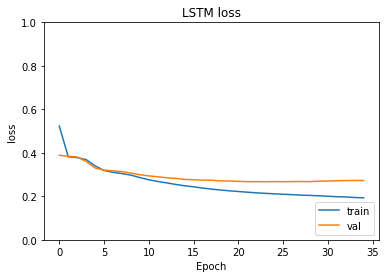

In [84]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('LSTM loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.ylim(0,1)
plt.legend(['train', 'val'], loc='lower right')
plt.show()

In [85]:
# Final evaluation of the model
scores = model.evaluate(padded_docs_test, y_test.values)

print("Accuracy: %.2f%%" % (scores[1]*100))

115/115 [==============================] - 0s 2ms/step - loss: 0.2735 - accuracy: 0.4353
Accuracy: 43.53%


# Save Model

In [0]:
model.save('/content/gdrive/My Drive/Colab Notebooks/TA/Model/modelCNN_nostopword.h5')

# Predict and Result

## Predict Data Test

In [0]:
predict = model.predict(padded_docs_test)
predict_train = model.predict(padded_docs_train)
predict_val = model.predict(padded_docs_val)
thresholds=0.5

In [0]:
def labelSetAccuracy(y_true, y_pred):
    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
#         print('\nset_true: {0}'.format(set_true))
#         print('set_pred: {0}'.format(set_pred))
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = len(set_true.intersection(set_pred))/\
                    float( len(set_true.union(set_pred)) )
        #print('tmp_a: {0}'.format(tmp_a))
        acc_list.append(tmp_a)
    return np.mean(acc_list)

In [89]:
pred_test = predict.copy()
pred_test[pred_test>=0.5] = 1
pred_test[pred_test<0.5] = 0
acc = accuracy_score(y_test.values,pred_test)
haml_loss = hamming_loss(y_test.values,pred_test)
label_acc = labelSetAccuracy(y_test.values,pred_test)
print("threshold = ",thresholds)
print("exact accuracy = ", acc)
print("hamming loss = ",haml_loss)
print("label based accuracy = ",label_acc)
print("==============================")

threshold =  0.5
exact accuracy =  0.5475543478260869
hamming loss =  0.1068840579710145
label based accuracy =  0.6765863310904072


In [90]:
pred_train = predict_train.copy()
pred_train[pred_train>=0.5] = 1
pred_train[pred_train<0.5] = 0
acc = accuracy_score(y_train.values,pred_train)
haml_loss = hamming_loss(y_train.values,pred_train)
label_acc = labelSetAccuracy(y_train.values,pred_train)
print("threshold = ",thresholds)
print("exact accuracy = ", acc)
print("hamming loss = ",haml_loss)
print("label based accuracy = ",label_acc)
print("==============================")


threshold =  0.5
exact accuracy =  0.6344759891271519
hamming loss =  0.07511577569717105
label based accuracy =  0.7673040921795075


In [91]:
pred_val = predict_val.copy()
pred_val[pred_val>=0.5] = 1
pred_val[pred_val<0.5] = 0
acc = accuracy_score(y_val.values,pred_val)
haml_loss = hamming_loss(y_val.values,pred_val)
label_acc = labelSetAccuracy(y_val.values,pred_val)
print("threshold = ",thresholds)
print("exact accuracy = ", acc)
print("hamming loss = ",haml_loss)
print("label based accuracy = ",label_acc)
print("==============================")

threshold =  0.5
exact accuracy =  0.5577445652173914
hamming loss =  0.10711050724637682
label based accuracy =  0.6851319875776397


## Analysis Result

### Data Validation Predict Result Analysis

In [0]:
data_val = pd.DataFrame(data=X_val,columns=['Tweet_Parsed']).join(y_val).reset_index(drop=True)

In [93]:
data_val.head()

,Tweet_Parsed,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong
0,so much berengsek people in the world,1,1,0,1,0,0,0,0,1,0,1,0
1,so how can i get my rekening berengsek rekenin...,0,1,0,0,0,0,0,0,0,0,0,0
2,rt user dasar bajing url,0,1,0,0,0,0,0,0,0,0,0,0
3,user karena kecebong tidak akan aku pria lajan...,1,1,0,1,0,0,0,0,1,0,1,0
4,rt user tidak ada urus monyet aku break home t...,1,1,1,0,0,0,0,0,1,1,0,0


In [0]:
data_val_predict = pd.DataFrame(data=X_val,columns=['Tweet_Parsed']).reset_index(drop=True).join(pd.DataFrame(data=pred_val, columns=y_val.columns))

In [95]:
data_val_predict.head()

,Tweet_Parsed,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong
0,so much berengsek people in the world,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,so how can i get my rekening berengsek rekenin...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,rt user dasar bajing url,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
3,user karena kecebong tidak akan aku pria lajan...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,rt user tidak ada urus monyet aku break home t...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Check Number of Label on Predict Data

In [0]:
label_size0_val = []
label_size1_val = []

for i in data_val.columns[1:]:
    label_size0_val.append(len(data_val[data_val[i]==0]))
    label_size1_val.append(len(data_val[data_val[i]==1]))

label_size0_val_predict = []
label_size1_val_predict = []

for i in data_val_predict.columns[1:]:
    label_size0_val_predict.append(len(data_val_predict[data_val_predict[i]==0]))
    label_size1_val_predict.append(len(data_val_predict[data_val_predict[i]==1]))

In [0]:
dat_anls_val = pd.DataFrame({
    'label' : data_val.columns[1:],
    'stats' : ["negative" for i in range(len(data_val.columns[1:]))],
    'jumlah' : label_size0_val
}).append(
    pd.DataFrame({
        'label' : data_val.columns[1:],
        'stats' : ["positive" for i in range(len(data_val.columns[1:]))],
        'jumlah' : label_size1_val
    })
)

# dat_anls_val = dat_anls_val.set_index(['label'], drop=True)

dat_anls_val_predict = pd.DataFrame({
    'label' : data_val_predict.columns[1:],
    'stats' : ["negative" for i in range(len(data_val_predict.columns[1:]))],
    'jumlah' : label_size0_val_predict
}).append(
    pd.DataFrame({
        'label' : data_val_predict.columns[1:],
        'stats' : ["positive" for i in range(len(data_val_predict.columns[1:]))],
        'jumlah' : label_size1_val_predict
    })
)

# dat_anls_val_predict = dat_anls_val_predict.set_index(['label'], drop=True)

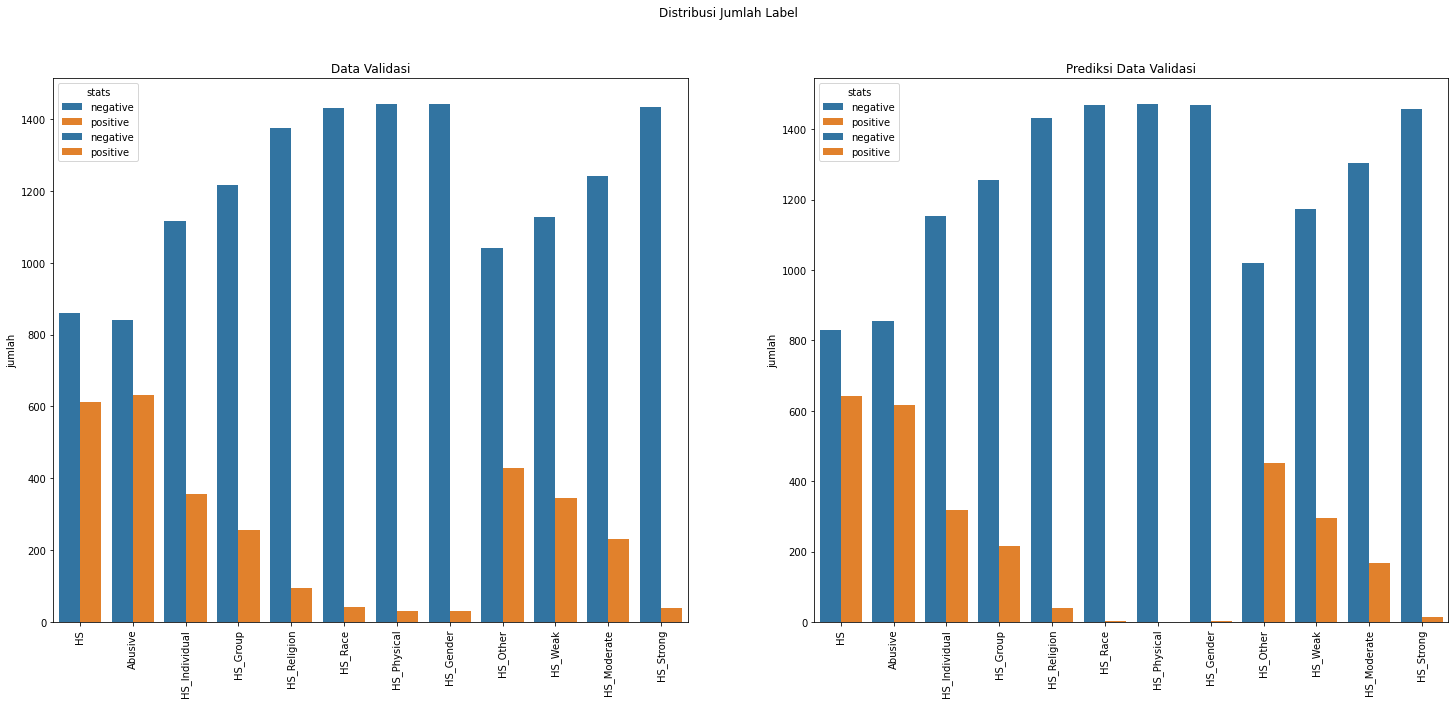

In [98]:
plt.figure(figsize=(25,10))
plt.suptitle('Distribusi Jumlah Label')

plt.subplot(1,2,1)
sns.barplot(x="label", y="jumlah",hue="stats", data=dat_anls_val).set_xticklabels(sns.barplot(x="label", y="jumlah",hue="stats", data=dat_anls_val).get_xticklabels(),rotation=90)
plt.title("Data Validasi")
plt.xlabel('')

plt.subplot(1,2,2)
sns.barplot(x="label", y="jumlah",hue="stats", data=dat_anls_val_predict).set_xticklabels(sns.barplot(x="label", y="jumlah",hue="stats", data=dat_anls_val_predict).get_xticklabels(),rotation=90)
plt.title("Prediksi Data Validasi")
plt.xlabel('')

plt.show()

In [99]:
pd.DataFrame({
    "label" : data_val.columns[1:],
    "negative (true)" : dat_anls_val[dat_anls_val['stats'] == "negative"]["jumlah"].values,
    "positive (true)" : dat_anls_val[dat_anls_val['stats'] == "positive"]["jumlah"].values,
    "negative (predict)" : dat_anls_val_predict[dat_anls_val_predict['stats'] == "negative"]["jumlah"].values,
    "positive (predict)" : dat_anls_val_predict[dat_anls_val_predict['stats'] == "positive"]["jumlah"].values
})

,label,negative (true),positive (true),negative (predict),positive (predict)
0,HS,859,613,829,643
1,Abusive,840,632,855,617
2,HS_Individual,1115,357,1155,317
3,HS_Group,1216,256,1257,215
4,HS_Religion,1376,96,1431,41
5,HS_Race,1431,41,1469,3
6,HS_Physical,1441,31,1471,1
7,HS_Gender,1441,31,1470,2
8,HS_Other,1042,430,1020,452
9,HS_Weak,1128,344,1175,297


#### OOV Check

In [0]:
def generate_ngrams(s):
    
    # Break sentence in the token, remove empty tokens
    tokens = [token for token in s.str.split(" ") if token != ""]
    
    # Use the zip function to help us generate n-grams
    # Concatentate the tokens into ngrams and return
    ngrams = np.concatenate(tokens)
    return ngrams

def oov(fitur,token):
    outOfVocab = []
    for i in token:
        if i not in fitur:
            outOfVocab.append(i)
    return outOfVocab

def oov_count(oovList):
    oovCount = {}
    for i in oovList:
        if i in oovCount.keys():
            oovCount[i] = oovCount[i]+1
        else:
            oovCount[i] = 1
    return oovCount

In [0]:
join_data_val = data_val.join(data_val_predict.drop(['Tweet_Parsed'],axis=1),rsuffix="_predict")

In [0]:
miss_exact_tweet_val = join_data_val[(join_data_val["HS"]!=join_data_val["HS_predict"]) | (join_data_val["Abusive"] != join_data_val["Abusive_predict"]) | (join_data_val["HS_Individual"] != join_data_val["HS_Individual_predict"]) | (join_data_val["HS_Group"] != join_data_val["HS_Group_predict"]) | (join_data_val["HS_Religion"] != join_data_val["HS_Religion_predict"]) | (join_data_val["HS_Race"] != join_data_val["HS_Race"]) | (join_data_val["HS_Physical"] != join_data_val["HS_Physical_predict"]) | (join_data_val["HS_Gender"] != join_data_val["HS_Gender_predict"]) | (join_data_val["HS_Other"] != join_data_val["HS_Other_predict"]) | (join_data_val["HS_Weak_predict"] != join_data_val["HS_Weak_predict"]) | (join_data_val["HS_Moderate_predict"] != join_data_val["HS_Moderate_predict"]) | (join_data_val["HS_Strong_predict"] != join_data_val["HS_Strong_predict"])]

In [0]:
oov_val = oov(vect.index_word.values(), generate_ngrams(miss_exact_tweet_val['Tweet_Parsed']))
oov_val_count = oov_count(oov_val)

In [104]:
oov_val_count

{'': 920,
 'ache': 1,
 'adele': 1,
 'admirer': 1,
 'advertise': 1,
 'aese': 1,
 'afford': 1,
 'afterwards': 1,
 'ahad': 1,
 'akil': 1,
 'aktris': 1,
 'alia': 1,
 'alin': 2,
 'ancient': 1,
 'antagonist': 1,
 'apki': 1,
 'apko': 1,
 'apostate': 1,
 'appologize': 1,
 'arrogance': 1,
 'aur': 1,
 'baa': 1,
 'baasyir': 1,
 'backpass': 2,
 'badassly': 1,
 'bai': 1,
 'barakat': 1,
 'barter': 1,
 'behead': 1,
 'belaganya': 1,
 'belepotan': 1,
 'bengkok': 1,
 'berlusconi': 1,
 'berus': 1,
 'besan': 1,
 'bish': 1,
 'bjp': 3,
 'bludgers': 1,
 'boikottouslesjours': 1,
 'brainer': 1,
 'briziek': 1,
 'budhis': 1,
 'buntel': 1,
 'butah': 1,
 'carrier': 1,
 'cashflow': 1,
 'ci': 1,
 'cingkrang': 1,
 'civilization': 1,
 'cloudforest': 1,
 'colonise': 1,
 'coloniser': 1,
 'comunis': 1,
 'congklak': 1,
 'contribute': 1,
 'cordi': 1,
 'coworker': 1,
 'cynical': 1,
 'daesung': 1,
 'deandra': 1,
 'determine': 1,
 'devastate': 1,
 'didi': 1,
 'dihadang': 1,
 'ditho': 1,
 'diz': 1,
 'dollar': 1,
 'dulmatin': 1

In [105]:
print("number of OOV words : ", len(oov_val))
print("number of unique OOV words : ", len(oov_val_count))

number of OOV words :  1213
number of unique OOV words :  280


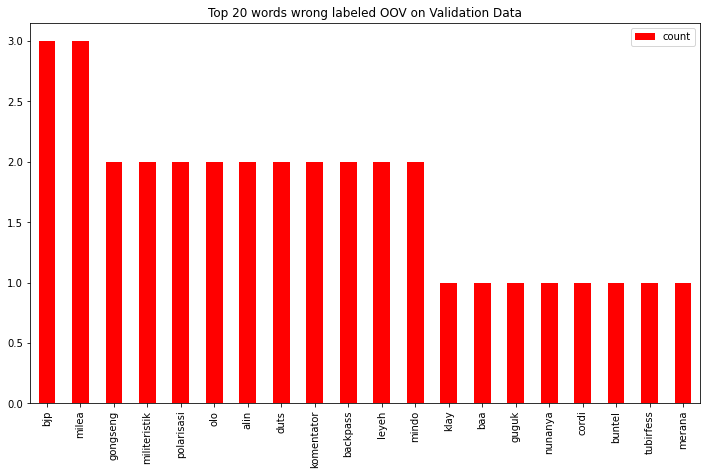

In [106]:
df_oov_val = pd.DataFrame(oov_val_count.items(),columns=["Tweet","count"])
df_oov_val.sort_values(['count'],ascending=False)[1:21].plot(
    kind='bar', y='count',x='Tweet', color='red', title='Top 20 words wrong labeled OOV on Validation Data', figsize=(12,7))
plt.xlabel("")
plt.show()

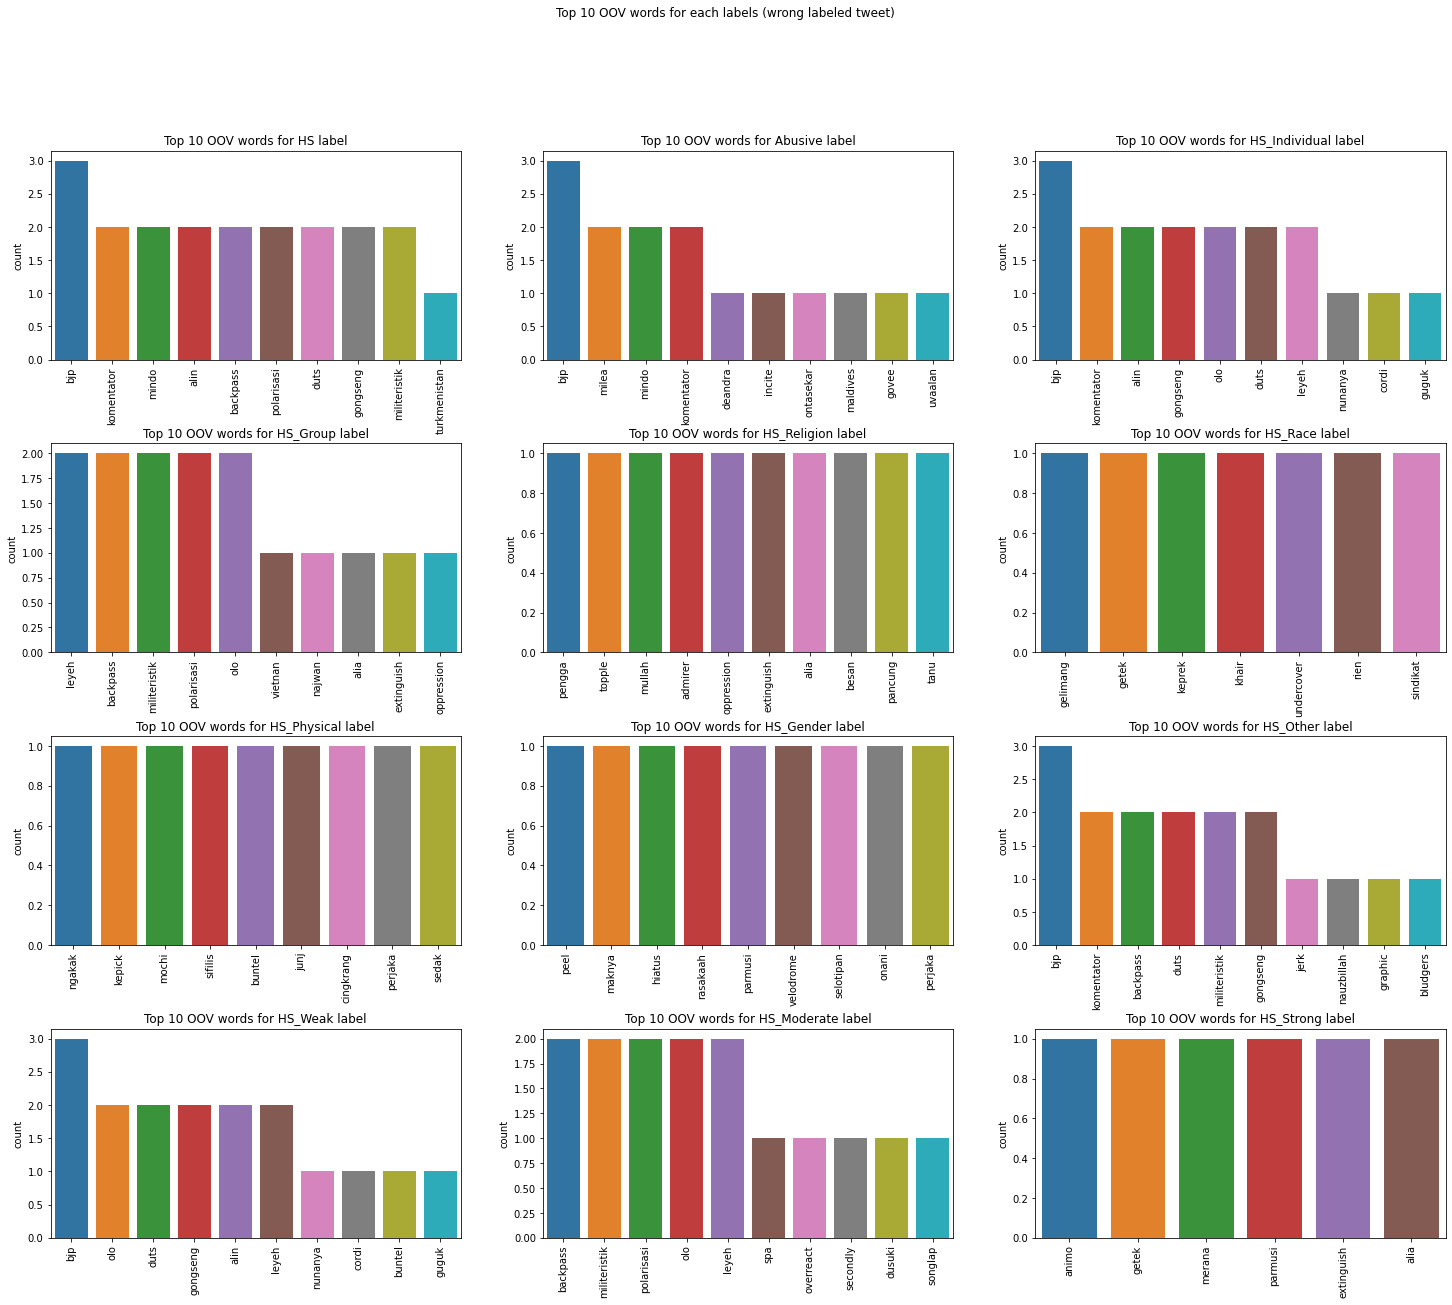

In [107]:
target = y_val.columns

plt.figure(figsize=(25,20))
plt.suptitle('Top 10 OOV words for each labels (wrong labeled tweet)')
for i in range (len(target)):
    plt.subplot(4,3,i+1)
    plt.subplots_adjust(hspace=0.4)
    wrongtweet = join_data_val[join_data_val[target[i]]!=join_data_val[target[i]+str("_predict")]]
    wrongtoken = generate_ngrams(wrongtweet['Tweet_Parsed']).tolist()
    wrong_oov = oov(vect.index_word.values(), wrongtoken)
    wrong_oov_count = oov_count(wrong_oov)
    frame = pd.DataFrame(wrong_oov_count.items(),columns=["Tweet","count"])
    frame = frame.sort_values(['count'],ascending=False)[1:11]
    sns.barplot(x="Tweet", y="count", data=frame).set_xticklabels(sns.barplot(x="Tweet", y="count", data=frame).get_xticklabels(),rotation=90)
    title='Top 10 OOV words for '+str(target[i])+" label"
    plt.title(title)
    plt.xlabel("")

#### Tweet Check

In [108]:
miss_exact_tweet_val['Tweet_Parsed'].values.tolist()

['so much berengsek people in the world',
 'rt user dasar bajing url',
 'rt user tidak ada urus monyet aku break home tidak begitu begitu amat malah pukul sama teman teman aku  kaya raya tidak ada tidak ada h ',
 'rt user  tai  tidak ada  mau join tag close agency basic ',
 'user user bacot  kalian ',
 'bahas islam rusak nilai user kuat karakter lalu revitalisasi didik nilai',
 'user kamu kafir banci   ampun sudah kafir banci lagi jangan sedih  cong kamu google  kafir banci kayak kamu ',
 'user mau naik apa seperti bodoh amat tidak pengaruh keleees lihat poll google minta presiden  ganti apa apa apa ganti presiden pak ogah ganti presiden',
 'ajar tapi apa the point kamu maksud anjing itu predator ke kucing itu prey i think kamu should get back to school he there a joke around kamu laugh my as off',
 'rt user user apa tidak bosan gaya monoton dari tahun satu sampai  gaya jual citra dengan pasang wajah melas terus rakyat saja ',
 'i deserve a date dengan user jembut  ',
 'user user janga

In [109]:
miss_exact_tweet_val.iloc[:,1:-12].columns

Index(['HS', 'Abusive', 'HS_Individual', 'HS_Group', 'HS_Religion', 'HS_Race',
       'HS_Physical', 'HS_Gender', 'HS_Other', 'HS_Weak', 'HS_Moderate',
       'HS_Strong'],
      dtype='object')

In [110]:
miss_exact_tweet_val.iloc[:,-12:].values.tolist()

[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0],
 [1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0],
 [0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
 [1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
 [1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
 [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0],
 [1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

### Data Test Predict Result Analysis

In [0]:
data_test_predict = pd.DataFrame(data=data_test['Tweet'],columns=['Tweet']).reset_index(drop=True).join(pd.DataFrame(data=pred_test, columns=y_test.columns)).join(pd.DataFrame(data=data_test['Tweet_Parsed'],columns=['Tweet_Parsed']).reset_index(drop=True))

#### Check Number of Label on Predict Data

In [0]:
label_size0_test = []
label_size1_test = []

for i in data_test.columns[1:-1]:
    label_size0_test.append(len(data_test[data_test[i]==0]))
    label_size1_test.append(len(data_test[data_test[i]==1]))

label_size0_test_predict = []
label_size1_test_predict = []

for i in data_test_predict.columns[1:-1]:
    label_size0_test_predict.append(len(data_test_predict[data_test_predict[i]==0]))
    label_size1_test_predict.append(len(data_test_predict[data_test_predict[i]==1]))

In [0]:
dat_anls_test = pd.DataFrame({
    'label' : data_test.columns[1:-1],
    'stats' : ["negative" for i in range(len(data_test.columns[1:-1]))],
    'jumlah' : label_size0_test
}).append(
    pd.DataFrame({
        'label' : data_test.columns[1:-1],
        'stats' : ["positive" for i in range(len(data_test.columns[1:-1]))],
        'jumlah' : label_size1_test
    })
)

# dat_anls_test = dat_anls_test.set_index(['label'], drop=True)

dat_anls_test_predict = pd.DataFrame({
    'label' : data_test_predict.columns[1:-1],
    'stats' : ["negative" for i in range(len(data_test_predict.columns[1:-1]))],
    'jumlah' : label_size0_test_predict
}).append(
    pd.DataFrame({
        'label' : data_test_predict.columns[1:-1],
        'stats' : ["positive" for i in range(len(data_test_predict.columns[1:-1]))],
        'jumlah' : label_size1_test_predict
    })
)

# dat_anls_test_predict = dat_anls_test_predict.set_index(['label'], drop=True)

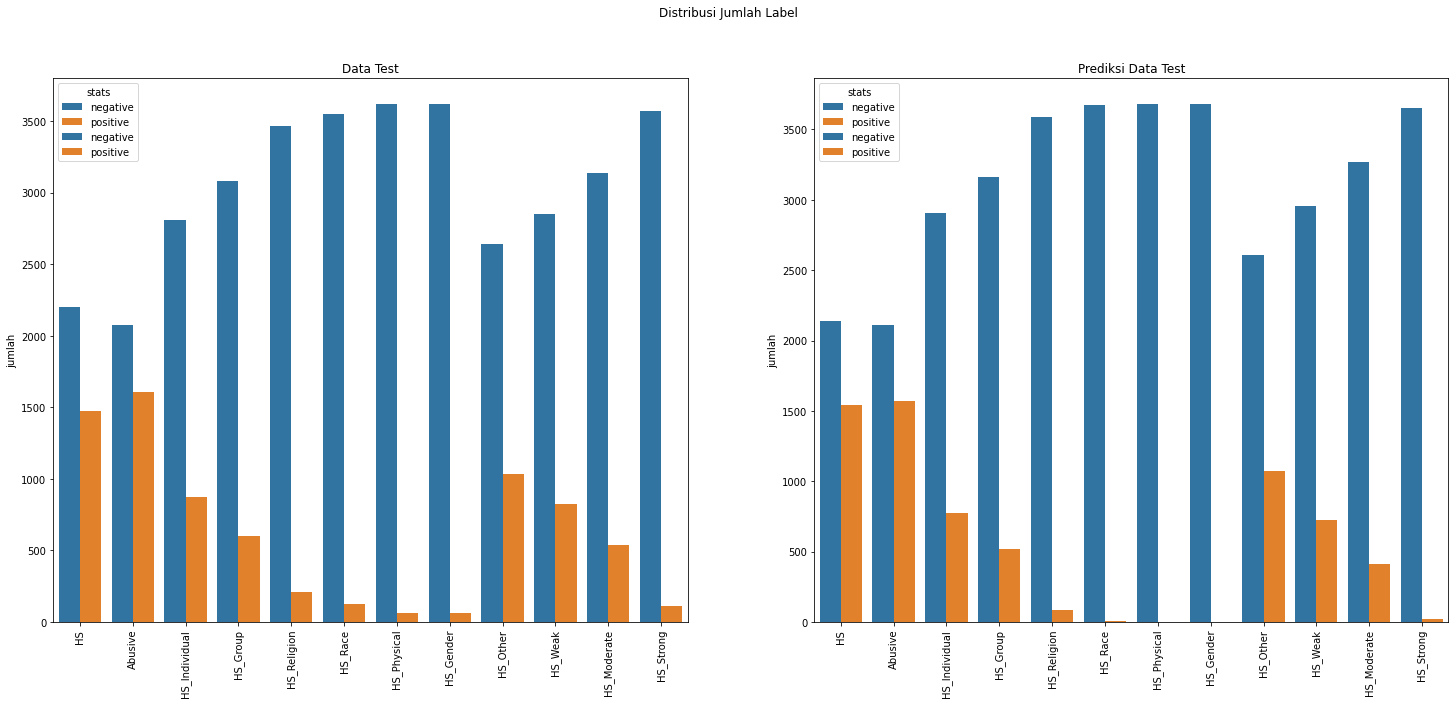

In [114]:
plt.figure(figsize=(25,10))
plt.suptitle('Distribusi Jumlah Label')

plt.subplot(1,2,1)
sns.barplot(x="label", y="jumlah",hue="stats", data=dat_anls_test).set_xticklabels(sns.barplot(x="label", y="jumlah",hue="stats", data=dat_anls_test).get_xticklabels(),rotation=90)
plt.title("Data Test")
plt.xlabel('')

plt.subplot(1,2,2)
sns.barplot(x="label", y="jumlah",hue="stats", data=dat_anls_test_predict).set_xticklabels(sns.barplot(x="label", y="jumlah",hue="stats", data=dat_anls_test_predict).get_xticklabels(),rotation=90)
plt.title("Prediksi Data Test")
plt.xlabel('')

plt.show()

In [115]:
pd.DataFrame({
    "label" : data_test.columns[1:-1],
    "negative (true)" : dat_anls_test[dat_anls_test['stats'] == "negative"]["jumlah"].values,
    "positive (true)" : dat_anls_test[dat_anls_test['stats'] == "positive"]["jumlah"].values,
    "negative (predict)" : dat_anls_test_predict[dat_anls_test_predict['stats'] == "negative"]["jumlah"].values,
    "positive (predict)" : dat_anls_test_predict[dat_anls_test_predict['stats'] == "positive"]["jumlah"].values
})

,label,negative (true),positive (true),negative (predict),positive (predict)
0,HS,2204,1476,2139,1541
1,Abusive,2075,1605,2108,1572
2,HS_Individual,2806,874,2907,773
3,HS_Group,3078,602,3159,521
4,HS_Religion,3467,213,3591,89
5,HS_Race,3551,129,3676,4
6,HS_Physical,3617,63,3678,2
7,HS_Gender,3616,64,3678,2
8,HS_Other,2643,1037,2608,1072
9,HS_Weak,2854,826,2957,723


#### OOV Check

In [0]:
join_data_test = data_test.join(data_test_predict.drop(['Tweet','Tweet_Parsed'],axis=1),rsuffix="_predict")

In [0]:
miss_exact_tweet_test = join_data_test[(join_data_test["HS"]!=join_data_test["HS_predict"]) | (join_data_test["Abusive"] != join_data_test["Abusive_predict"]) | (join_data_test["HS_Individual"] != join_data_test["HS_Individual_predict"]) | (join_data_test["HS_Group"] != join_data_test["HS_Group_predict"]) | (join_data_test["HS_Religion"] != join_data_test["HS_Religion_predict"]) | (join_data_test["HS_Race"] != join_data_test["HS_Race"]) | (join_data_test["HS_Physical"] != join_data_test["HS_Physical_predict"]) | (join_data_test["HS_Gender"] != join_data_test["HS_Gender_predict"]) | (join_data_test["HS_Other"] != join_data_test["HS_Other_predict"]) | (join_data_test["HS_Weak_predict"] != join_data_test["HS_Weak_predict"]) | (join_data_test["HS_Moderate_predict"] != join_data_test["HS_Moderate_predict"]) | (join_data_test["HS_Strong_predict"] != join_data_test["HS_Strong_predict"])]

In [0]:
oov_test = oov(vect.index_word.values(), generate_ngrams(miss_exact_tweet_test['Tweet_Parsed']))
oov_test_count = oov_count(oov_test)

In [119]:
oov_test_count

{'': 2297,
 'abur': 1,
 'activate': 1,
 'administrative': 1,
 'adora': 1,
 'afai': 1,
 'afganistan': 1,
 'afno': 1,
 'afreen': 2,
 'afterall': 1,
 'agel': 1,
 'agony': 1,
 'airplane': 1,
 'akademi': 1,
 'akin': 1,
 'alang': 2,
 'alienate': 1,
 'alina': 1,
 'allegiance': 1,
 'allen': 1,
 'allende': 1,
 'alonso': 1,
 'alpha': 1,
 'alucard': 1,
 'ancurnya': 1,
 'andino': 1,
 'anjiiirr': 1,
 'anon': 1,
 'apocalypse': 1,
 'appeal': 2,
 'appologise': 1,
 'apprently': 1,
 'ardhog': 1,
 'ashraf': 1,
 'asus': 1,
 'atip': 1,
 'atmosphere': 1,
 'authenticate': 1,
 'auti': 2,
 'avert': 1,
 'babang': 3,
 'backward': 1,
 'badik': 1,
 'bagak': 1,
 'bagdadi': 1,
 'bahana': 1,
 'baja': 1,
 'bajul': 1,
 'bald': 1,
 'balur': 2,
 'bangsar': 1,
 'bantat': 1,
 'baperki': 1,
 'barkley': 1,
 'barrier': 1,
 'basket': 1,
 'bat': 1,
 'batch': 1,
 'becky': 2,
 'beer': 1,
 'beggar': 1,
 'bell': 1,
 'belong': 1,
 'benalu': 1,
 'bersyariah': 1,
 'besanding': 1,
 'besengek': 1,
 'beyek': 1,
 'bhencho': 1,
 'biodivers

In [120]:
print("number of OOV words : ", len(oov_test))
print("number of unique OOV words : ", len(oov_test_count))

number of OOV words :  3216
number of unique OOV words :  834


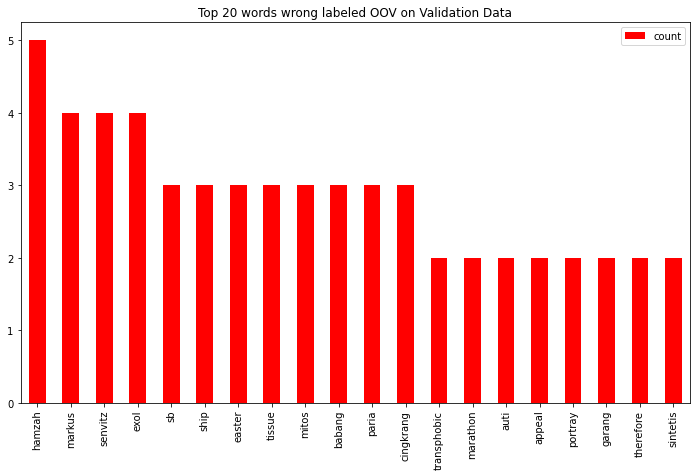

In [121]:
df_oov_test = pd.DataFrame(oov_test_count.items(),columns=["Tweet","count"])
df_oov_test.sort_values(['count'],ascending=False)[1:21].plot(
    kind='bar', y='count',x='Tweet', color='red', title='Top 20 words wrong labeled OOV on Validation Data', figsize=(12,7))
plt.xlabel("")
plt.show()

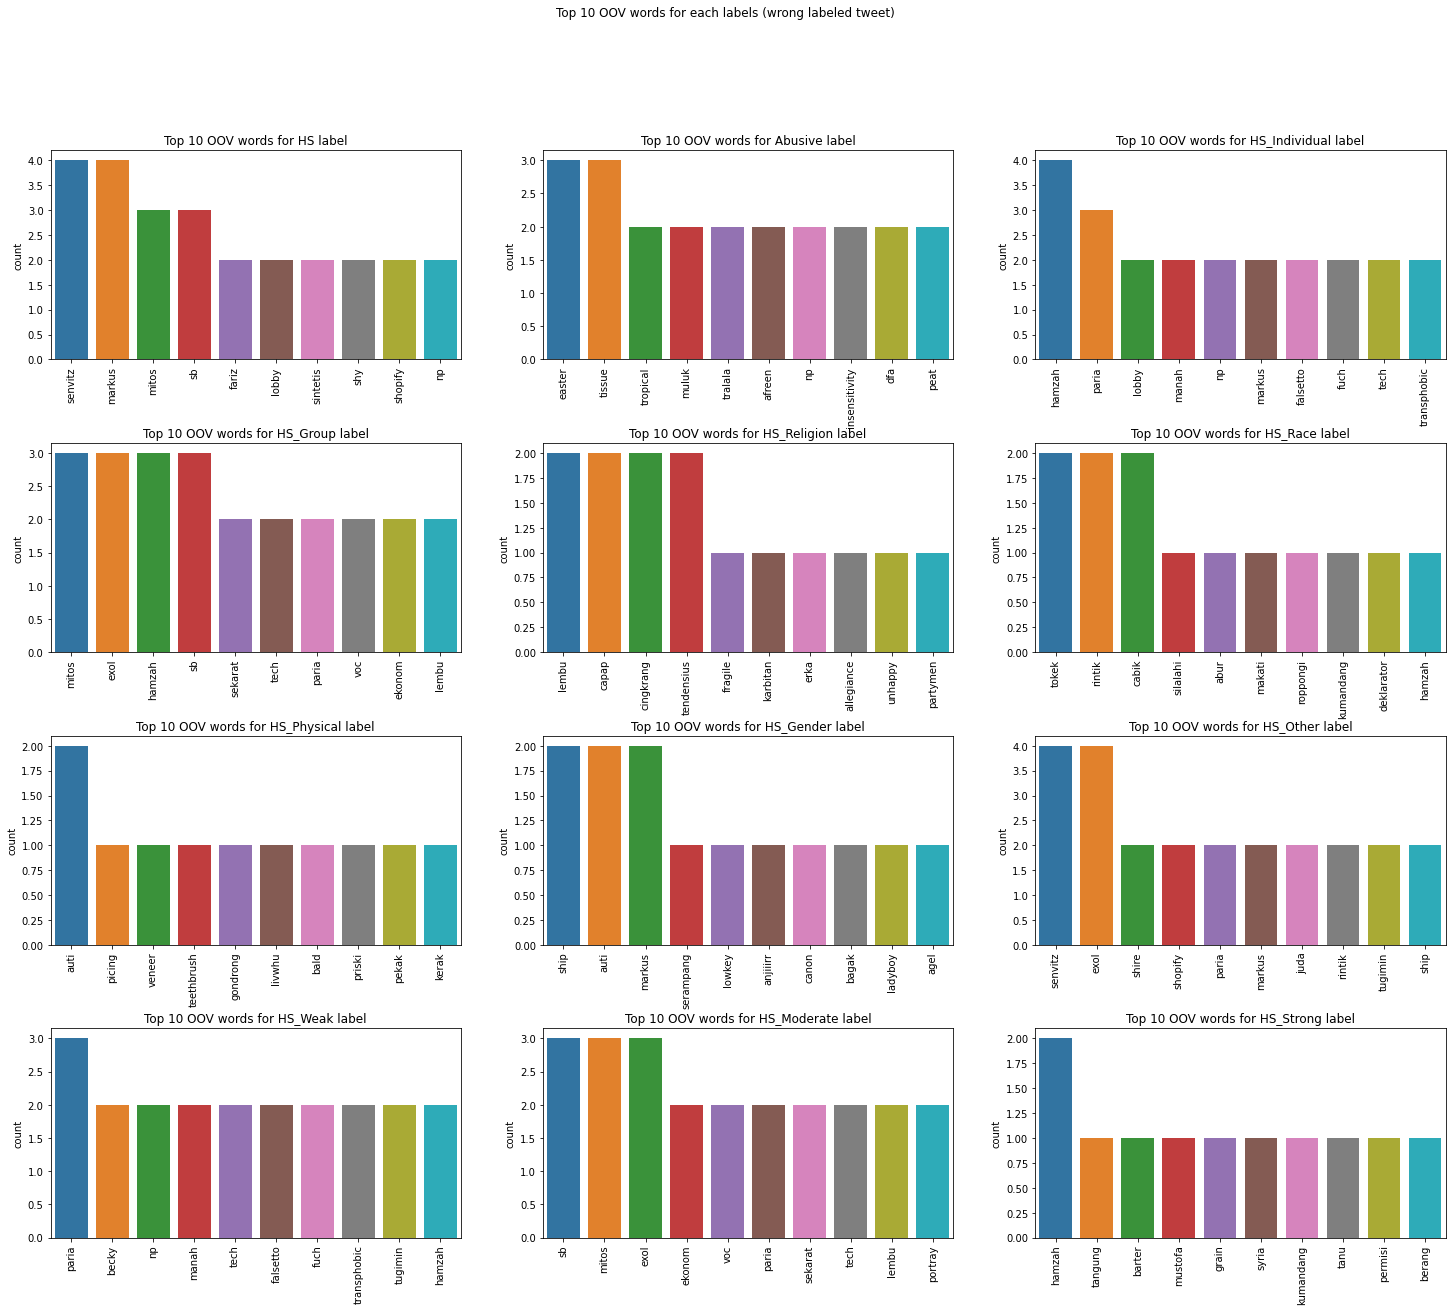

In [122]:
target = y_test.columns

plt.figure(figsize=(25,20))
plt.suptitle('Top 10 OOV words for each labels (wrong labeled tweet)')
for i in range (len(target)):
    plt.subplot(4,3,i+1)
    plt.subplots_adjust(hspace=0.4)
    wrongtweet = join_data_test[join_data_test[target[i]]!=join_data_test[target[i]+str("_predict")]]
    wrongtoken = generate_ngrams(wrongtweet['Tweet_Parsed']).tolist()
    wrong_oov = oov(vect.index_word.values(), wrongtoken)
    wrong_oov_count = oov_count(wrong_oov)
    frame = pd.DataFrame(wrong_oov_count.items(),columns=["Tweet","count"])
    frame = frame.sort_values(['count'],ascending=False)[1:11]
    sns.barplot(x="Tweet", y="count", data=frame).set_xticklabels(sns.barplot(x="Tweet", y="count", data=frame).get_xticklabels(),rotation=90)
    title='Top 10 OOV words for '+str(target[i])+" label"
    plt.title(title)
    plt.xlabel("")

#### Tweet Check

In [123]:
miss_exact_tweet_test['Tweet'].values.tolist()

['Does insulting one for being "Cina", "Kafir", make you a better Muslim?',
 "USER Khan yg ngajarin si garong kafir'",
 "USER Anak pecun... ga jauh2 dr hobi zina.. haha'",
 'USER Udah siap di demo berjilid2 sama bani cingkrang ? Malaysia memberlakukan syariat Islam, tapi melegalkan perjudian dengan berbagai syarat dan ketentuan yg "strict".\'',
 "Hamdalah. Kelar juga ini fitur keparat.'",
 "USER Jancuk! Pingin gue tabok itu anak'",
 "USER Sebenernya siapa sih yang mempunyai hak untuk menyatakan bahwa orang itu kafir? Dan jika semua orang mempunyai hak, apa kriteria kafir itu?'",
 'I like you. You like him, itukan berengsek :3 #nyampah',
 '#MataNajwaDebatJakarta lucu banget jawaban ahok.. gak nyambung. Ditanya apa di jawab apa. Kena skak mat d pertanyaan isu agama tdi. Dasar cina tolol hahaha',
 "USER Astagaaa.. Sewa pecun skalian ga pak?'",
 "USER Jadi pilih. Mau bunga bangkai apa karangan bunga hahaha'",
 "Gak habis pikir deh gmn kalo kunti itu bs masuk rumah. Gak berani bayangin gue.

In [124]:
miss_exact_tweet_test['Tweet_Parsed'].values.tolist()

['do insult one for be cina kafir make you a good muslim ',
 'user   ajar  garong kafir ',
 'user anak pecun tidak jauh jauh dari hobi zina  ',
 'user sudah siap di demo jilid jilid sama ban cingkrang malaysia laku syariat islam tapi legal judi dengan bagai syarat dan tentu  strict ',
 'hamdalah selesai juga ini fitur keparat ',
 'user jancuk ingin aku tabok itu anak ',
 'user benar siapa   punya hak untuk nyata bahwa orang itu kafir dan jika semua orang punya hak apa kriteria kafir itu ',
 'i like you you like him itu  berengsek sampah',
 ' mata najwa debat jakarta lucu banget jawab ahok tidak sambung tanya apa di jawab apa kena sekak mat di tanya isu agama tadi dasar cina tolol ',
 'user astaga sewa pecun sekali tidak pak ',
 'user jadi pilih mau bunga bangkai apa karang bunga  ',
 'tidak habis pikir  bagaimana kalau kunti itu bisa masuk rumah tidak berani bayang aku kamu berani bayang end ',
 'when you cheat and menang you ve distinguish yourself a a loser shame on you malaysia sea 

In [125]:
miss_exact_tweet_test.iloc[:,1:-13].columns

Index(['HS', 'Abusive', 'HS_Individual', 'HS_Group', 'HS_Religion', 'HS_Race',
       'HS_Physical', 'HS_Gender', 'HS_Other', 'HS_Weak', 'HS_Moderate',
       'HS_Strong'],
      dtype='object')

In [126]:
# real label
miss_exact_tweet_test.iloc[:,1:-13].values.tolist()

[[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0],
 [1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0],
 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0],
 [1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0],
 [1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0],
 [1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0],
 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 0, 1, 0, 0, 0, 0, 0,

In [127]:
miss_exact_tweet_test.iloc[:,-12:].values.tolist()

[[0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
 [1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0],
 [1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0

In [0]:
miss_exact_tweet_test.to_csv("/content/gdrive/My Drive/Colab Notebooks/TA/bestresult_CNN_nostopword.csv",index=False,sep=";")